In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader, Dataset

import torchvision
from torchvision import transforms

import numpy as np
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score

In [3]:
channel_stats = dict(mean=[0.4914, 0.4822, 0.4465],
                     std=[0.2470,  0.2435,  0.2616])

# see the paper for the proper augmentation
transform_weak = transforms.Compose([
    transforms.RandomCrop(size=32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(**channel_stats),
])

transform_strong = transforms.Compose([
    transforms.RandomResizedCrop(size=32),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(hue=[-0.1, 0.1]),
    transforms.ToTensor(),
    transforms.Normalize(**channel_stats),
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(**channel_stats),
])

### load cifar 10 dataset

In [4]:
train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)

supervised, unsupervised = random_split(train, [10000, 40000])

val = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_val)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
def plot(data, transform):
    
    x, y = data
    
    mean = torch.Tensor(channel_stats['std']).view(-1, 1, 1)
    
    std = torch.Tensor(channel_stats['mean']).view(-1, 1, 1)
    
    de_normalized = transform(x) * std + mean
        
    plt.imshow(de_normalized.permute(1, 2, 0))
    
    plt.title(train.classes[y])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


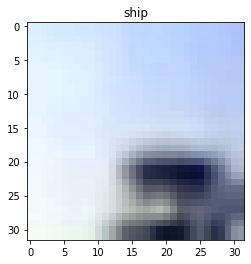

In [9]:
plot(train[100], transform_strong)

### DataLoaders

In [10]:
class SemiData(Dataset):
    
    def __init__(self, data, supervised = True):
        
        self.data = data
        
        self.supervised = supervised
        
    def __len__(self): return len(self.data)
    
    def __getitem__(self, idx):
        
        x, y = self.data[idx]
        
        x1 = transform_weak(x)
        x2 = transform_strong(x)
        
        if self.supervised:
            return x1, y
        else:
            return x1, x2

In [11]:
sup_batch_size = 128
mu = 4

sup_loader = DataLoader(SemiData(supervised, supervised=True), batch_size=sup_batch_size, shuffle=True, num_workers=15)

unsup_loader = DataLoader(SemiData(unsupervised, supervised=False), batch_size=sup_batch_size * mu, shuffle=True, num_workers=15)

val_loader = torch.utils.data.DataLoader(val, batch_size=100, shuffle=False, num_workers=15)

### Model

see Notebook **013 - Convolution Layer.ipynb**

$O = (I − K + 2 P)/S+1$

- O : output size
- I : input size
- K : kernel size
- P : padding
- S : stride

In [12]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fe = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1), # (32 - 3 + 2 * 0)/1 + 1 = 30
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1), # (30 - 3 + 2 * 0)/1 + 1 = 28
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2), # (28 - 4 + 2 * 0)/2 + 1 = 13
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2), # (13 - 3 + 2 * 0)/2 + 1 = 6
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # (6 - 2)/2 + 1 = 3
            nn.Dropout(0.1)
        )
        
        self.fc = nn.Linear(128 * 3 * 3, 10)
        
    def forward(self, x):
        
        # x of size [batch_size, 3, W, H]
        
        h = self.fe(x) # [batch_size, 128, 3, 3]
                
        h = h.view(-1, 128 * 3 * 3)
        
        return self.fc(h) # [batch_size, 10]

### Training loop

In [16]:
def train_fixMatch(model: nn.Module,
                    opt: torch.optim,
                    sup_loader: torch.utils.data.DataLoader,
                    unsup_loader: torch.utils.data.DataLoader,
                    tau: float=0.95,
                    alpha: float=0.5):
    
    model.train()
    
    for param in model.parameters():
        device = param.device
        break
    
    losses = []
    
    pbar = tqdm(sup_loader)
    
    unsup_iter = iter(unsup_loader)
    
    for batch_sup in pbar:
        
        model.zero_grad()
        
        # labelled data
        x_sup, y = batch_sup
        x_sup, y = x_sup.to(device), y.to(device)
        
        # unlabelled data
        try:
            x_weak, x_strong = next(unsup_iter)
        except StopIteration:
            unsup_iter = iter(unsup_loader)
            x_weak, x_strong = next(unsup_iter)
                
        x_weak, x_strong = x_weak.to(device), x_strong.to(device)
        
        # concat all x
        all_x = torch.cat([x_sup, x_weak, x_strong], dim=0)
        
        # compute logits
        all_logits = model(all_x)
        
        # logits and loss for labelled data
        logits_sup = all_logits[:x_sup.size(0)]
        loss_sup = F.cross_entropy(logits_sup, y)
        
        # logits for unlabelled data
        logits_unsup = all_logits[x_sup.size(0):]
        logits_weak, logits_strong = torch.chunk(logits_unsup, 2, dim=0)
        
        # stop gradient for weak augmented
        logits_weak = logits_weak.detach() 
        
        # compute class probailities
        probs_weak = F.softmax(logits_weak, dim=1)
        
        # compute pseudo labels (torch.max outputs the maximum values and the argmax)
        max_prob, pseudo_label = torch.max(probs_weak, dim=1)
        
        # [batch,]
        
        # mask for
        mask = (max_prob > tau).float() # [1, 0] [batch_size,]
                
        # mask non-confident prediction
        pseudo_label = pseudo_label.masked_fill(mask == 0, -1) # [3, -1, ...]
        
        # unsupervised loss by ignoring non-confident prediction
        loss_unsup = F.cross_entropy(logits_strong, pseudo_label, ignore_index=-1)
        
        # total loss
        loss = loss_sup + alpha * loss_unsup
        
        loss.backward()

        opt.step()
        
        loss_item = loss.item()
        
        losses.append(loss_item)
        
        pbar.set_description(f'train_loss = {np.array(losses).mean(): .3f}')
        
    return np.array(losses).mean()

@torch.no_grad()
def validate(model: nn.Module, dataloader: torch.utils.data.DataLoader):
    
    model.eval()
    
    for param in model.parameters():
        device = param.device
        break
     
    labels_all = []
    logits_all = []
    
    for x, y in dataloader:

        x, y = x.to(device), y.to(device)

        logits = model(x)
        
        labels_all += y.cpu().numpy().tolist()
        logits_all += logits.cpu().numpy().tolist()
        
    prediction = np.argmax(np.array(logits_all), axis=-1)
    
    acc = accuracy_score(labels_all, prediction)
                    
    return acc

### Training

In [19]:
# initialize model

model = ConvNet().cuda()

opt = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [20]:
for t in range(5):
    train_fixMatch(model, opt, sup_loader, unsup_loader, tau=0.9, alpha=0.3)
    val_acc = validate(model, val_loader)
    print(val_acc)

  0%|          | 0/79 [00:00<?, ?it/s]

tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(1., device='cuda:0')
tensor(3., device='cuda:0')
tensor(14., device='cuda:0')
tensor(19., device='cuda:0')
tensor(24., device='cuda:0')
tensor(20., device='cuda:0')
tensor(13., device='cuda:0')
tensor(6., device='cuda:0')
tensor(8., device='cuda:0')
tensor(3., device='cuda:0')
tensor(6., device='cuda:0')
tensor(6., device='cuda:0')
tensor(7., device='cuda:0')
tensor(10., device='cuda:0')
tensor(10., device='cuda:0')
tensor(8., device='cuda:0')
tensor(16., device='cuda:0')
tensor(14., device='cuda:0')
tensor(10., device='cuda:0')
tensor(12., device='cuda:0')
tensor(7., device='cuda:0')
tensor(9., device='cuda:0')
tensor(7., device='cuda:0')
tensor(7., device='cuda:0')
tensor(6., device='cuda:0')
tensor(9., device='cuda:0')
tensor(2., device='cuda:0')
tensor(8., device='cuda:0')
tensor(7., device='cuda:0')
tensor(8.

KeyboardInterrupt: 